This notebook aims to obtain microsim data in order to assist with the development of the PVD incidence rate model. We have access to a PVD prevalence model but no incidence model is available. So, the plan is to implement the PVD prevalence model in microsim, run microsim to get data, and then use that data to develop an incidence rate model consistent with the prevalence model. 

More specifically, when the population is created, we use the PVD prevalence model to get the PVD risks. We draw a random number, between 0 and 1. Based on that comparison we decide who had PVD when the population was created. We then advance the population by a year. Estimate the prevalence PVD risks again using the new risk factors. If the random draw we did before fell in between the PVD risk of year 0 and the PVD risk of year 1, then that person was assigned as getting PVD during year 1 (so that person contributed to the PVD incidence rate). Finally, the population, the ones that got PVD during year 1 and the ones that did not, are used in a logistic regression model (this is done in a separate notebook with R).

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from microsim.population import NHANESDirectSamplePopulation
from microsim.sim_settings import simSettings

In [3]:
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

seedSequence = np.random.SeedSequence()
rngStream = np.random.default_rng(seed=seedSequence)

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [4]:
%%time
popSize = 300000
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

CPU times: user 8.37 s, sys: 496 ms, total: 8.87 s
Wall time: 31.4 s


In [5]:
%%time
alive, dead = pop.advance_vectorized(0,rng=rngStream)

CPU times: user 4min 57s, sys: 11 s, total: 5min 8s
Wall time: 22min 30s


In [6]:
alive.shape

(300000, 99)

In [7]:
#this prevalence model is based on the publication https://doi.org/10.1097%2FMD.0000000000003454
from microsim.pvd_model import PVDPrevalenceModel

In [8]:
#get the prevalence of PVD in the microsim population
a = list(map(lambda x:  setattr(x, "_pvd", [PVDPrevalenceModel().estimate_next_risk(x, rngStream, False)]), pop._people))

In [9]:
#pop._people.iloc[4]._pvd

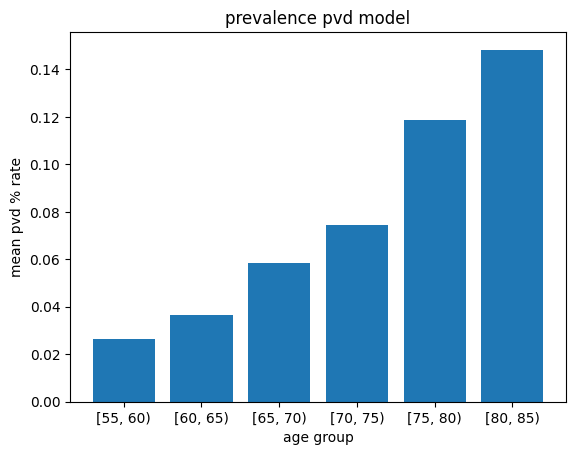

In [10]:
#do the bin counting for the baseline model
ageList = list()
pvdList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age
    pvdList += p._pvd 
        
basePvd = pd.DataFrame(list(zip(ageList,pvdList)), columns=["age","pvd"])
basePvd["age"]=basePvd["age"].astype('int')
basePvd["ageInterval"] = pd.cut(basePvd["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

basePvdMeansByAgeGroup = basePvd.groupby("ageInterval").agg({'pvd' : 'mean'})
basePvdMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  basePvdMeansByAgeGroup.index.array]

labels = basePvdMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in basePvdMeansByAgeGroup.values[1:]]

fig, ax = plt.subplots()
ax.bar(labels, values)
plt.xlabel("age group")
plt.ylabel("mean pvd % rate")
plt.title("prevalence pvd model")
plt.show()

In [11]:
#let's do the same thing using the dataframe version
alive["pvd0"] = alive.apply(lambda x: PVDPrevalenceModel().estimate_next_risk_vectorized(x, rngStream, False), axis=1)

In [12]:
#keep the initial risk factors etc because these will be lost next
alive0 = alive

In [13]:
%%time
#advance the population by a single year (incidence rate is regarding new cases during a year)
alive, dead = pop.advance_vectorized(1,rng=rngStream)

CPU times: user 14min 49s, sys: 27.8 s, total: 15min 17s
Wall time: 28min 1s


In [14]:
#now estimate the prevalence risk of the now 1 year older population
alive["pvd1"] = alive.apply(lambda x: PVDPrevalenceModel().estimate_next_risk_vectorized(x, rngStream, False), axis=1)

In [15]:
#alive0[["pvd0"]].head()

In [16]:
#alive["pvd1"].head()

In [17]:
#keep from the original dataframe only the ones that remained alive in this 1 year older population
#and copy quantities I do not have at the current dataframe
alive["pvd0"] = alive0.loc[alive0["populationIndex"].isin(alive["populationIndex"].tolist()), ("pvd0")]
alive["smokingStatus0"] = alive0.loc[alive0["populationIndex"].isin(alive["populationIndex"].tolist()), ("smokingStatus")]

In [18]:
#alive[["pvd0","pvd1"]]

In [19]:
#alive0["hdl"].head(10)

In [20]:
#alive["hdl0"].head(10)

In [21]:
#this is the data I need to obtain an incidence rate model
data = alive.loc[:,("age0","sbp0","dbp0","totChol0","hdl0","gender","smokingStatus0","raceEthnicity","pvd0","pvd1")]

In [22]:
data.shape

(300000, 10)

In [23]:
#data["pvd0"] = data["pvd0"].astype(int)
#data["pvd1"] = data["pvd1"].astype(int)

In [24]:
#calculate some quantities I need for the model
data["pulsePressure0S"] = (data["sbp0"] - data["dbp0"])/10.
data["age0S"] = data["age0"]/10.
data["tchdlRatio0"] = data["totChol0"]/data["hdl0"]

In [25]:
#the PVD prevalence model has only 4 categories for race/ethnicity so I need to map the microsim categories to these 4 levels
def raceEthnicityIn4Levels(x):
    if (x==1)|(x==2):
        return 1
    else:
        return x
    
data["raceEthnicity0"] = data["raceEthnicity"].apply(raceEthnicityIn4Levels)

In [26]:
#same thing for the smoking status
def smokingStatusIn2Levels(x):
    if (x==0):
        return 0
    else:
        return 1
    
data["smokingStatus0"] = data["smokingStatus0"].apply(smokingStatusIn2Levels)

In [27]:
#this random draw is the single random number for each person that will be used to obtain the incidence model
data["draw"] = rngStream.uniform(size=popSize)

data["pvd0Binary"] = (data["pvd0"]>data["draw"]).astype(int)
data["pvd1Binary"] = (data["pvd1"]>data["draw"]).astype(int)

#keep only the people that did not get PVD during the use of the prevalence model at the beginning
data = data[data["pvd0Binary"]==0]

In [28]:
#data.loc[:,("pvd0","pvd0Binary","pvd1","pvd1Binary","draw")].head()

In [29]:
data.to_csv("/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA/pvdModelDevelopment.csv", index=False)